# Импорт библиотек и определение констант

In [1]:
import pandas as pd
from pprint import pprint
import json
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from IPython.display import display

RANDOM_SEED = 42
PRICE_CORRECTION = 0.85
VAL_SIZE= 0.2

# Загрузка данных и первый обзор

In [2]:
# датасет из base_line
train_basic = pd.read_csv('./all_auto_ru_09_09_2020.csv')
# датасет, найденный на кагл
train_extra = pd.read_csv('./train_df_full.csv')
# тестовый датасет
test = pd.read_csv('./test.csv')
# датасет для сабминта на ЛБ
sample_submission = pd.read_csv('./sample_submission.csv')

In [3]:
# Посмотрим информацию по составу датасетов
# print("\n"+"="*60+" train_basic")
# display(train_basic.info())
# print("\n"+"="*60+" train_extra")
# display(train_extra.info())
# print("\n"+"="*60+" test")
# display(test.info())

In [4]:
# Визуально посмотрим на данные в каждом датасете
# display(train_basic.head(3))
# display(train_extra.head(3))
# display(test.head(3))

In [5]:
# Видно, что в "train_basic" "Комплектация" это "complectation_dict", и "model" это "model_name". Переименуем
train_basic.rename(
    columns={
        "Комплектация": "complectation_dict",
        "model": "model_name",
    },
    inplace=True,
)

# Используемые функции

In [6]:
def describe_column(df, column):
    total = len(df[column])
    nan_count = len(df[df[column].isnull()][column])
    nan_count_df0 = len(df[(df[column].isnull()) & (df.data_type==0)][column])
    nan_count_df1 = len(df[(df[column].isnull()) & (df.data_type==1)][column])
    nan_count_df2 = len(df[(df[column].isnull()) & (df.data_type==2)][column])
    print(f"{'Data type':>20}: {str(df[column].dtype)}")
    print(f"{'Total':>20}: 100.0% = {total}")
    print(f"{column+' nan':>20}: {round(nan_count/total*100,1):>5}% = {nan_count} ({nan_count_df0}/{nan_count_df1}/{nan_count_df2})")
    df[column].value_counts()
    if len(df[column].unique()) < 11:
        display(df[column].value_counts())


def map_rus_to_end(value, dict_):
    if value is np.nan:
        return np.nan
    if value in list(dict_.values()):
        return value
    return dict_.get(value, np.nan)

def fill_from_groupped_series(groupped_series, brand, model_name, default_value):
    try:
        result = groupped_series[brand][model_name].index[0]
    except:
        result = default_value
    return result

def var_name(obj):
    return [name for name in globals() if globals()[name] is obj]

def print_collums_diff(df1, df2):
    print(f"Колонки есть в '{var_name(df1)[0]}', но нет в '{var_name(df2)[0]}':")
    print(
        "\t", ", ".join(
            set(df1.columns).difference(set(df2.columns))
        )
    )
    print(f"Колонки есть в '{var_name(df2)[0]}', но нет в '{var_name(df1)[0]}':")
    print(
        "\t", ", ".join(
            set(df2.columns).difference(set(df1.columns))
        )
    )    

def text_to_json(value):
    if value is np.nan:
        return np.nan
    
    if not isinstance(value, str):
        return np.nan
    
    if value[1] == "'":
        value = value.replace("'", '"')
    value = value.lower()

    try:
        result = json.loads(value)
    except:
        return np.nan

    return result


def equipment_dict_to_set(value):
    result = text_to_json(value)
    if result is np.nan:
        return set()

    if len(result) == 0:
        return set()

    return set(result.keys())


def complectation_dict_to_set(value):
    result = text_to_json(value)

    if result is np.nan:
        return set()

    if len(result) == 0:
        return set()

    try:
        result = result["available_options"]
    except:
        return set()

    return set(result)

# Объеденение датасетов

In [7]:
# проверим, какая разница в столбцах между датасетами
print_collums_diff(train_basic, test)
print("-"*10)
print_collums_diff(train_basic, train_extra)
print("-"*10)
print_collums_diff(test, train_extra)

Колонки есть в 'train_basic', но нет в 'test':
	 start_date, price, hidden
Колонки есть в 'test', но нет в 'train_basic':
	 sell_id, image, equipment_dict, priceCurrency, super_gen, parsing_unixtime, car_url, model_info, vendor
----------
Колонки есть в 'train_basic', но нет в 'train_extra':
	 start_date, hidden
Колонки есть в 'train_extra', но нет в 'train_basic':
	 sell_id, image, equipment_dict, date_added, priceCurrency, super_gen, parsing_unixtime, car_url, views, model_info, region, vendor
----------
Колонки есть в 'test', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'test':
	 views, region, date_added, price


По результатам сравнения колонок делаем изменения:
- train_basic:
    - hidden: удаляем
    - start_date: удаляем
    - equipment_dict: добавляем со всем значениями = nan для объеденения датасетов
    - super_gen: добавляем со всем значениями = nan для объеденения датасетов
    - model_info: добавляем со всем значениями = nan для объеденения датасетов
- train_extra:
    - image: удаляем
    - priceCurrency: удаляем
    - vendor: удаляем, определяется производителем (маркой) авто
    - car_url: удаляем
    - sell_id: удаляем
    - views: удаляем
    - parsing_unixtime: удаляем
    - date_added: удаляем
    - region: удаляем
- test:
    - image: удаляем
    - priceCurrency: удаляем
    - vendor: удаляем, определяется производителем (маркой) авто
    - car_url: удаляем
    - sell_id: удаляем
    - parsing_unixtime: удаляем
    - price: добавляем для объеденения датасетов

In [8]:
# удалим описанные выше колонки
train_basic.drop(
    [
        "hidden",
        "start_date",
    ],
    axis=1,
    inplace=True,
)
train_extra.drop(
    [
        "image",
        "priceCurrency",
        "vendor",
        "car_url",
        "sell_id",
        "views",
        "parsing_unixtime",
        "date_added",
        "region",
    ],
    axis=1,
    inplace=True,
)
test.drop(
    [
        "image",
        "priceCurrency",
        "vendor",
        "car_url",
        "sell_id",
        "parsing_unixtime",
    ],
    axis=1,
    inplace=True,
)

In [9]:
# в "test" добавим столбец "price" для дальнейшего объединения датасетов, это наш целевой параметр и он отсутсвует в тестовом датасете
test["price"] = 0
# в "train_basic" добавляем недостающие для объединения столбцы
train_basic["super_gen"] = np.nan
train_basic["model_info"] = np.nan
train_basic["equipment_dict"] = np.nan

In [10]:
# проверим еще раз разницу в колонках:
print_collums_diff(train_basic, test)
print("-"*10)
print_collums_diff(train_basic, train_extra)
print("-"*10)
print_collums_diff(test, train_extra)

Колонки есть в 'train_basic', но нет в 'test':
	 
Колонки есть в 'test', но нет в 'train_basic':
	 
----------
Колонки есть в 'train_basic', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'train_basic':
	 
----------
Колонки есть в 'test', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'test':
	 


In [11]:
# отличий нет, объединяем, добавив еще признак "data_type" для разделения различных датасетов
# 0 - тестовый для сабмита
# 1 - обучение из base line
# 2 - обучение с кагла
test["data_type"] = 0
train_basic["data_type"] = 1
train_extra["data_type"] = 2
# и объединим датасеты в один общий
df = pd.concat([test, train_basic, train_extra], join='inner', ignore_index=True)

# Обработка данных
Идем по колонкам и чистим мусор, заполняем NaN.

## equipment
Есть две колонки, где присутсвует информация о комплектации: "complectation_dict" и "equipment_dict". Создаем новую колонку "equipment" на основе "equipment_dict" путем перевода опций авто в set(). Далее "complectation_dict" переводим в json и извлекаем лист "available_options", который описывает опции и добавляем их в "equipment". После этого "complectation_dict" и "equipment_dict" можно удалять.

In [12]:
df["equipment"] = df["equipment_dict"].apply(equipment_dict_to_set)
df["complectation_dict_tmp"] = df["complectation_dict"].apply(complectation_dict_to_set)
df["equipment"] = df.apply(
    lambda row: row["equipment"].union(row["complectation_dict_tmp"]),
    axis=1,
)
df.drop(
    [
        "complectation_dict_tmp",
        "complectation_dict",
        "equipment_dict",
    ],
    axis=1,
    inplace=True,
) 


## super_gen
Есть колонка "super_gen", в которой может присутсвовать различная инфоормация: марка/пробег/год выпуска и тд. Попробуем распарсить эту колонку во временные колонки, что бы потом ими воспользоваться для заполнения пропусков:
- tmp_engine_type
- tmp_engine_power
- tmp_transmission
- tmp_year
- tmp_mileage
- tmp_mark
- tmp_model
- tmp_state

"super_gen" далее удалим

In [13]:
def parse_super_gen(value):
    result = {}
    # columns = ["tmp_engine_type", "tmp_engine_power", "tmp_transmission", "tmp_year", "tmp_mileage", "tmp_brand", "tmp_model", "tmp_state"]
    columns = ["engine_type", "power", "transmission", "year", "km-age", "mark", "model", "state"]
    for column in columns:
        result["tmp_"+column] = np.nan

    value = text_to_json(value)
    if value is np.nan:
        return result
    if "sale-data-attributes" in value:
        value = value["sale-data-attributes"]
    for column in columns:
        result["tmp_"+column] = value.get(column, np.nan)
    if result["tmp_engine_type"] is np.nan:
        result["tmp_engine_type"] = value.get("engine-type", np.nan)

    # result["tmp_engine_type"] = value.get("engine-type", np.nan)
    # if result["tmp_engine_type"] is np.nan:
    #     result["tmp_engine_type"] = value.get("engine_type", np.nan)
    # result["tmp_engine_power"] = value.get("power", np.nan)
    # result["tmp_transmission"] = value.get("transmission", np.nan)
    # result["tmp_year"] = value.get("year", np.nan)
    # result["tmp_mileage"] = value.get("km-age", np.nan)
    # result["tmp_brand"] = value.get("mark", np.nan)
    # result["tmp_model"] = value.get("model", np.nan)
    # result["tmp_state"] = value.get("state", np.nan)
    
    return result

df["super_gen"] = df["super_gen"].apply(parse_super_gen)
df = pd.concat([df.drop(["super_gen"], axis=1), df["super_gen"].apply(pd.Series)], axis=1)

## engine_power
Есть две колонки: "tmp_engine_power" и "enginePower". Форматируем "enginePower" в числовое представление. Потом проопуски пытаемся заполнить из на основе "tmp_engine_power". Сводим все в колонку "engine_power", исходные данные дропаем.

In [15]:
def format_engine_power(value):
    if value is np.nan:
        return np.nan
    if isinstance(value, float):
        return value
    if not isinstance(value, str):
        return np.nan
    power_value = value.split()[0]
    if power_value.isdigit():
        return int(power_value)
    else:
        return np.nan

In [16]:
df["engine_power"] = df.enginePower.apply(format_engine_power)

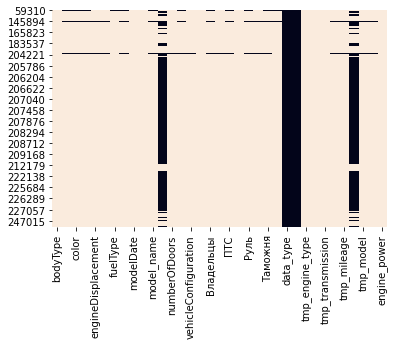

In [17]:
# оценим, а что там в целом с пропусками в датасете, где пропущен "engine_power" 
fig = plt.figure()
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.engine_power.isna()].isna(), cbar=False)
plt.show()

In [18]:
# судя по графику, информация по этим объявлениям отсутсвует полностью. 
# нет смысла что-то с ними делать, поэтом просто дропнем их, исключив датасет "test"
df.drop(df[(df.engine_power.isna()) & (df.data_type != 0)].index, inplace=True)
# и удалим уже ненужные колонки
df.drop(["tmp_engine_power", "enginePower"], axis=1, inplace=True) 

## brand
Есть две колонки: "tmp_brand" и "brand". Форматируем "brand" и смотрим, есть ли пропуски, если есть, пробуем заполнить из "tmp_brand", потом "tmp_brand" удаляем.

In [19]:
print(list(df.brand.unique()))

['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA', 'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU', 'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG']


In [20]:
# видно, что с колонкой "brand" все хорошо, приведем в нижний регистр и удалим "tmp_brand" (т.к. пропусков в "brand" нет)
df.brand = df.brand.str.lower()
df.drop(["tmp_brand"], axis=1, inplace=True) 

## year
Есть две колонки: "productionDate" и "tmp_year" отвечающие за год производства. Форматируем "productionDate". Потом проопуски пытаемся заполнить из на основе "tmp_year". Сводим все в колонку "year", исходные данные дропаем.

In [21]:
print(list(df.productionDate.unique()))

[2014.0, 2017.0, 2012.0, 2011.0, 2019.0, 2018.0, 2010.0, 2020.0, 2016.0, 2013.0, 2006.0, 2007.0, 2015.0, 2005.0, 2008.0, 2009.0, 1997.0, 2004.0, 2002.0, 1987.0, 2003.0, 2001.0, 1976.0, 2000.0, 1998.0, 1995.0, 1999.0, 1993.0, 1939.0, 1996.0, 1984.0, 1990.0, 1991.0, 1992.0, 1989.0, 1982.0, 1985.0, 1994.0, 1938.0, 1981.0, 1988.0, 1983.0, 1980.0, 1986.0, 1978.0, 1970.0, 1979.0, 1977.0, 1972.0, 1975.0, 1969.0, 1950.0, 1953.0, 1949.0, 1937.0, 1959.0, 1968.0, 1936.0, 1904.0, 1974.0, 1967.0, 1961.0, 1960.0, 1965.0, 1963.0, 1957.0, 1952.0, 1973.0, 1948.0, 1955.0, 1964.0, 1971.0, 1931.0, 1927.0, 1923.0, 1924.0, 1932.0, 1951.0, 1954.0, 1966.0, 2021.0]


In [22]:
# с годом выпуска машины все хорошо, переименум "productionDate" и удалим "tmp_year"
df.rename(columns={"productionDate": "year"}, inplace=True)
df.drop(["tmp_year"], axis=1, inplace=True) 

## model
Есть две колонки: "model_name" и "tmp_model" отвечающие за модель. Как и выше, форматируем "model_name", пытаемся заполнить пропуски и удаляем ненужные колонки.

In [23]:
# сначала приводим все к одному регистру, затем разбираемся с пробелами
df.model_name = df.model_name.str.lower()

In [24]:
model_dict = {
    "\+": "_plus_",
    "'": "_",
    "\s+": "_",
    "-+": "_",
    "\(|\)": "",
    ":": "_",
}
for old_str, new_str in model_dict.items():
    df.loc[:,"model_name"] = df.loc[:,"model_name"].str.replace(old_str, new_str, regex=True)
    df.loc[:,"tmp_model"] = df.loc[:,"tmp_model"].str.replace(old_str, new_str, regex=True)

In [25]:
# список моделей по брендам 
# for brand in df.brand.unique():
#     model_count = str(df.groupby("brand")["model_name"].nunique()[brand])
#     pprint("-"*10 + brand + "-"*10+" models count: "+model_count)
#     pprint(sorted(df.loc[(df.brand==brand) & ~(df.model_name.isna()),"model_name"].unique()))

In [26]:
def format_model_name(df, brand, column_name, old_str, new_str):
    df.loc[df.brand==brand,column_name] = df.loc[df.brand==brand,column_name].str.replace(old_str, new_str, regex=True)
    return True

In [27]:
# чистка моделей для mercedes

model_dict = {
    "190_w201": "w201",
    "190_sl": "w121",
    "_класс": "",
    "_klasse": "",
    "_class": "",
    "s_maybach": "maybach_s",
    "^amg_(.*)$": "\\1_amg",
}

for old_str, new_str in model_dict.items():
    format_model_name(df, "mercedes", "model_name", old_str, new_str)
    format_model_name(df, "mercedes", "tmp_model", old_str, new_str)

In [28]:
# чистка моделей для bmw
model_dict = {
    "_серии": "",
    "^02$": "2",
    "^3..$": "3",
    "([a-zA-Z]+)tourer": "_\\1_tourer",
    "grand_tourer": "gran_tourer",
    "_m$": "m",
    "(\d)+er$": "\\1",
}
for old_str, new_str in model_dict.items():
    format_model_name(df, "bmw", "model_name", old_str, new_str)
    format_model_name(df, "bmw", "tmp_model", old_str, new_str)


In [29]:
# чистка моделей для toyota
model_dict = {"rav4": "rav_4"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "toyota", "model_name", old_str, new_str)
    format_model_name(df, "toyota", "tmp_model", old_str, new_str)

In [30]:
# чистка моделей для nissan
model_dict = {"rnessa": "r_nessa"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "nissan", "model_name", old_str, new_str)
    format_model_name(df, "nissan", "tmp_model", old_str, new_str)

In [31]:
# чистка моделей для honda
model_dict = {"odyssey_north_america": "odyssey_na"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "honda", "model_name", old_str, new_str)
    format_model_name(df, "honda", "tmp_model", old_str, new_str)

In [32]:
# чистка моделей для mitsubishi
model_dict = {"delica_d2": "delica_d_2"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "mitsubishi", "model_name", old_str, new_str)
    format_model_name(df, "mitsubishi", "tmp_model", old_str, new_str)

In [33]:
# чистка моделей для audi
model_dict = {"rs_(\d)": "rs\\1", "rs_q3": "rsq3"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "audi", "model_name", old_str, new_str)
    format_model_name(df, "audi", "tmp_model", old_str, new_str)

In [34]:
# чистка моделей для skoda
model_dict = {"105,_120": "120", "100_series":"100"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "skoda", "model_name", old_str, new_str)
    format_model_name(df, "skoda", "tmp_model", old_str, new_str)

In [35]:
# чистка моделей для volvo
model_dict = {"_series": "", "_cc": "_cross_country"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "volvo", "model_name", old_str, new_str)
    format_model_name(df, "volvo", "tmp_model", old_str, new_str)

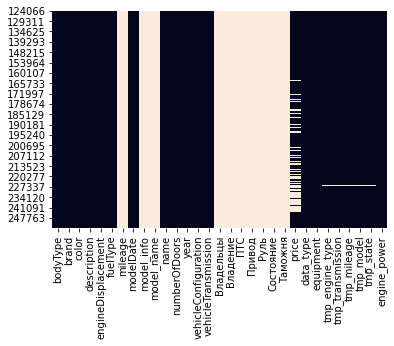

In [36]:
fig = plt.figure()
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.model_name.isna()].isna(), cbar=False)
plt.show()

In [37]:
df.model_name.fillna(df.tmp_model, inplace=True)
df.drop(["tmp_model"], axis=1, inplace=True) 

In [38]:
# посмотрим, сколько пропусков в "model_name"
df[df.model_name.isna()].shape[0]

29

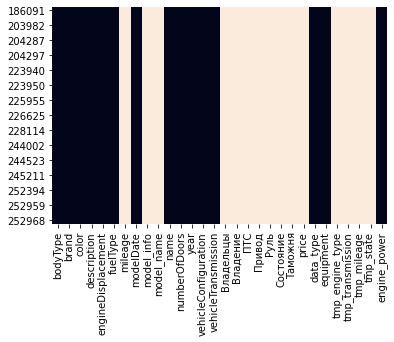

In [39]:
# графически
fig = plt.figure()
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.model_name.isna()].isna(), cbar=False)
plt.show()

In [40]:
# видно, что записей с пропусками всего 29. и у них у всех отсутсвует "price", т.е. для нас эти записи бесполезны,
# проверим, что среди этих записей нет тестового датасета и удалим эти строки и колонку "tmp_model"
df[df.model_name.isna()].data_type.value_counts()

2    29
Name: data_type, dtype: int64

In [41]:
df.drop(df[(df.model_name.isna()) & (df.data_type != 0)].index, inplace=True)

## body_type
Тип кузова, пропусков нет. Форматируем следующим образом: все в lowercase и берем только первое слово, так как оно отвечает за тип.

In [42]:
# посмотреть список всех типов кузова
# pprint(sorted(list(df.bodyType.unique())))

In [43]:
# регистр
df.bodyType = df.bodyType.str.lower()
# береп первое слово
df.bodyType = df.bodyType.apply(lambda x: x.split()[0].strip())
df.bodyType = df.bodyType.apply(lambda x: x.split("-")[0].strip())

In [44]:
df.rename(columns={"bodyType": "body_type"}, inplace=True)

## color
цвет есть текстом и хексом. Пропусков нет, приводим все к одному виду.

In [45]:
# пропуски
df[df.color.isna()].shape[0]

0

In [46]:
# словарь для замены цвета на текст, ограничимся только нашими данными
color_dict = {
    '040001': 'чёрный',
    'EE1D19': 'красный',
    '0000CC': 'синий',
    'CACECB': 'серебристый',
    '007F00': 'зелёный',
    'FAFBFB': 'белый',
    '97948F': 'серый',
    '22A0F8': 'голубой',
    '660099': 'пурпурный',
    '200204': 'коричневый',
    'C49648': 'бежевый',
    'DEA522': 'золотистый',
    '4A2197': 'фиолетовый',
    'FFD600': 'жёлтый',
    'FF8649': 'оранжевый',
    'FFC0CB': 'розовый',
}
df.color.replace(to_replace=color_dict, inplace=True)


## description
удаляем колонку, текст произвольный, вряд ли трудозатраты на парсинг будет оправдан 

In [47]:
df.drop(["description"], axis=1, inplace=True) 

## engine_displacement
объем двигателя. парсим объем во float. пропуски в конце попробуем заполнить на онове модели и мощности двигателя.

In [48]:
def format_engine_displacement(value):
    r = re.search(r"(\d+\.\d+)", str(value))
    if r:
        return float(r.group(1))
    return np.nan

In [49]:
df["engine_displacement"] = df.engineDisplacement.apply(format_engine_displacement)
df.drop(["engineDisplacement"], axis=1, inplace=True) 

In [50]:
# пропусков достаточно много
df[df.engine_displacement.isna()].shape[0]

21538

In [51]:
# посмотрим, сколько пропусков в каждом из типов датасетов
# видим, что подавляющее большенство получилось от train_basic. 
df[df.engine_displacement.isna()].data_type.value_counts()

1    21068
2      415
0       55
Name: data_type, dtype: int64

In [52]:
# если посмотреть исходный датасет, то видно, что изначально вместо объема была модель
# а объем может быть получен из колонки "name"
train_basic.loc[6231,["name", "engineDisplacement"]]

name                  520i 2.0 AT (184 л.с.)
engineDisplacement                      520i
Name: 6231, dtype: object

In [53]:
df.engine_displacement.fillna(df.name, inplace=True)

In [54]:
df.engine_displacement = df.engine_displacement.apply(format_engine_displacement)

In [55]:
df[df.engine_displacement.isna()].data_type.value_counts()

2    413
1    109
0     55
Name: data_type, dtype: int64

In [56]:
# стало значительно лучше. теперь если посмотреть где пропуски, то можно увидеть, что это электрокары
# для них этот параметр не актуален, поэтом просто заполним пропуски нулями
df[df.engine_displacement.isna()].fuelType.unique()

array(['электро'], dtype=object)

In [57]:
df.engine_displacement.fillna(0, inplace=True)

## mileage
пробег

In [58]:
# посмотрим характеристики стобца
describe_column(df, "mileage")

           Data type: float64
               Total: 100.0% = 254020
         mileage nan:  10.6% = 26925 (0/0/26925)


In [59]:
# пропусков достаточно много, но все они из "train_extra", ранее мы парсили "super_gen" и там была опция "state"
# посмотрим, какие статусы у авто с пропусками пробега
df[df.mileage.isna()].tmp_state.unique()

array(['new'], dtype=object)

In [60]:
# получается все пропуски это новые авто, заполним все пропуски пробега нулями
df.mileage.fillna(0, inplace=True)

In [61]:
df.drop(["tmp_mileage"], axis=1, inplace=True)

## modelDate
Модельный год. У нас есть год выпуска авто, это более важнный фактор для цены. Скорее всего просто удалим этот столбец, но в конце, когда посмотрим на общую картиину и построим матрцу корреляции.

In [62]:
describe_column(df, "modelDate")

           Data type: float64
               Total: 100.0% = 254020
       modelDate nan:   0.0% = 0 (0/0/0)


In [63]:
# видно, что такие машины есть, но их мало,
# посмотрим, насколько лет расхождение
(df[df.modelDate > df.year].modelDate - df[df.modelDate > df.year].year).value_counts()

1.0    16
2.0     7
3.0     2
dtype: int64

In [64]:
# в основном это ошибка на 1 год, поэтому заменним для этих машин год выпуска на модельный
df.loc[df.year-df.modelDate < 0, "year"] = df.loc[df.year-df.modelDate < 0, "modelDate"]

In [65]:
df.rename(columns={"modelDate": "model_date"}, inplace=True)

## fuel_type
тип топлива (двигателя)

In [66]:
describe_column(df, "fuelType")

           Data type: object
               Total: 100.0% = 254020
        fuelType nan:   0.0% = 0 (0/0/0)


In [67]:
# пропусков нет, посмотрим на значения
df.fuelType.value_counts()

бензин     204034
дизель      47801
гибрид       1584
электро       581
газ            20
Name: fuelType, dtype: int64

In [68]:
engine_type_dict = {
    "бензин": "gasoline",
    "дизель": "diesel",
    "гибрид": "hybrid",
    "электро": "electro",
    "газ": "lpg",
}

df["engine_type"] = df["fuelType"].apply(map_rus_to_end, args=(engine_type_dict,))

In [69]:
set(df[(df.brand=="mercedes") & (df.data_type==2)].model_name.unique())-set(df[(df.brand=="mercedes") & (df.data_type==1)].model_name.unique())

{'clk_amg', 'eqv'}

In [70]:
df.drop(["fuelType", "tmp_engine_type"], axis=1, inplace=True)

## model_info
дропаем колонку, модель/производитель у нас уже заполнены, больше в "model_info" интересной информации нет

In [71]:
df.drop(["model_info"], axis=1, inplace=True)

## name
аналогично, модель/производитель/двигатель у нас уже заполнены, больше в "name" интересной информации нет

In [72]:
df.drop(["name"], axis=1, inplace=True)

## numberOfDoors
число дверей

In [73]:
describe_column(df, "numberOfDoors")

           Data type: float64
               Total: 100.0% = 254020
   numberOfDoors nan:   0.0% = 0 (0/0/0)


In [74]:
## посмотрим на значения 
df.numberOfDoors.value_counts()

5.0    160993
4.0     82898
2.0      6023
3.0      4104
0.0         2
Name: numberOfDoors, dtype: int64

In [75]:
# машины без дверей
df[df.numberOfDoors==0]

,body_type,brand,color,mileage,model_date,model_name,numberOfDoors,year,vehicleConfiguration,vehicleTransmission,...,Состояние,Таможня,price,data_type,equipment,tmp_transmission,tmp_state,engine_power,engine_displacement,engine_type
16944,кабриолет,mercedes,белый,48000.0,1904.0,simplex,0.0,1904.0,CABRIO MECHANICAL 5.3,механическая,...,Не требует ремонта,Растаможен,0.0,0,{},mechanical,NaN,32.0,5.3,gasoline
122751,кабриолет,mercedes,белый,48000.0,1904.0,simplex,0.0,1904.0,CABRIO MECHANICAL 5.3,MECHANICAL,...,NaN,True,12000000.0,1,{},NaN,NaN,32.0,5.3,gasoline


In [76]:
# оба кабриолеты, там, как минимум 2 двери есть, правим это
df.loc[df.numberOfDoors==0, "numberOfDoors"] = 2

In [77]:
df.rename(columns={"numberOfDoors": "number_of_doors"}, inplace=True)

## vehicleConfiguration
описание авто: модель/объем двигателя/трансмиссия. у нас уже это все есть, удаляем

In [78]:
df.drop(["vehicleConfiguration"], axis=1, inplace=True)

## transmission
тип трансмиссии

In [79]:
describe_column(df, "vehicleTransmission")

           Data type: object
               Total: 100.0% = 254020
vehicleTransmission nan:   0.0% = 0 (0/0/0)


In [80]:
df.vehicleTransmission.value_counts()

автоматическая      93424
AUTOMATIC           49218
вариатор            28446
MECHANICAL          25264
механическая        22694
роботизированная    20079
ROBOT                7871
VARIATOR             7024
Name: vehicleTransmission, dtype: int64

In [81]:
# меняем регистр и переводим все в английские имена
df.vehicleTransmission = df.vehicleTransmission.str.lower()

In [82]:
transmission_dict = {
    "механическая": "mechanical",
    "автоматическая": "automatic",
    "вариатор": "variator",
    "роботизированная": "robot",
}

df["transmission"] = df["vehicleTransmission"].apply(map_rus_to_end, args=(transmission_dict,))

In [83]:
df.transmission.value_counts()

automatic     142642
mechanical     47958
variator       35470
robot          27950
Name: transmission, dtype: int64

In [84]:
df.drop(["vehicleTransmission", "tmp_transmission"], axis=1, inplace=True)

## owners
число владельцев. помним, что у нас есть новые машины, поэтовы возможные пропуски в первую очередь проверим на состояние машины (новая и нет) и заполним нулями для новых авто. все остальное пропуски заполним единицами.

In [85]:
df.rename(columns={"Владельцы": "owners"}, inplace=True)

In [86]:
describe_column(df, "owners")

           Data type: object
               Total: 100.0% = 254020
          owners nan:  15.9% = 40513 (0/13588/26925)


In [87]:
df[df.owners.isna()].tmp_state.value_counts()

new    26925
Name: tmp_state, dtype: int64

In [88]:
# больше половины пропусков это новые авто, заполним это нулями
df.loc[(df.owners.isna()) & (df.tmp_state=="new"), "owners"] = 0

In [89]:
describe_column(df, "owners")

           Data type: object
               Total: 100.0% = 254020
          owners nan:   5.3% = 13588 (0/13588/0)


In [90]:
# все равно остались пропуски. теперь проверим, заполним пропуски нулями там, где нулевой пробег (mileage)
df[df.owners.isna()].mileage.value_counts()

0.0    13588
Name: mileage, dtype: int64

In [91]:
# все пропуски у авто с нулевым пробегом, считаем, что это новые машины и заполним владельцев нулями
df.loc[(df.owners.isna()) & (df.mileage==0), "owners"] = 0

In [92]:
# теперь посмотрим на сами значения
df.owners.value_counts()

3 или более    49759
1 владелец     40575
0              40513
3.0            36247
2 владельца    28655
2.0            21006
1.0            18536
1 владелец      9459
2 владельца     9270
Name: owners, dtype: int64

In [93]:
# пропусков у нас уже нет, поэтому просто возьмем первое число из текущих значений
df.owners = df.owners.apply(lambda x: float(str(x).split()[0]))

## ownership
с какого года авто у последнего владельца

In [94]:
describe_column(df, "Владение")

           Data type: object
               Total: 100.0% = 254020
        Владение nan:  78.2% = 198539 (22691/60176/115672)


In [95]:
# пропусков очень много, да и непонятно, что эта колонка может дать. удалим её
df.drop(["Владение"], axis=1, inplace=True)

## vehicle_licence (ПТС)
информация о ПТС, оригинал/дубликат

In [96]:
df.rename(columns={"ПТС": "vehicle_licence"}, inplace=True)

In [97]:
describe_column(df, "vehicle_licence")

           Data type: object
               Total: 100.0% = 254020
 vehicle_licence nan:  10.7% = 27287 (1/361/26925)


In [98]:
# пропусков довольно много, посмотрим какие значения есть
df.vehicle_licence.value_counts()

Оригинал     122683
ORIGINAL      78596
Дубликат      15034
DUPLICATE     10420
Name: vehicle_licence, dtype: int64

In [99]:
# нужно сменить регистр и заменить rus->eng, но сначала посмотрим на пропуски, а конкретне на пробег у машин с пропусками
df[df.vehicle_licence.isna()].mileage.value_counts()

0.0         27286
276000.0        1
Name: mileage, dtype: int64

In [100]:
# получается все, кроме одного, пропуски это новые авто. думаю для них можно поставить ПТС равным "original"
df.loc[(df.vehicle_licence.isna()) & (df.mileage==0), "vehicle_licence"] = "original"

In [101]:
# посмотрим на оставшееся авто
df[df.vehicle_licence.isna()]

,body_type,brand,color,mileage,model_date,model_name,number_of_doors,year,owners,vehicle_licence,...,Состояние,Таможня,price,data_type,equipment,tmp_state,engine_power,engine_displacement,engine_type,transmission
10412,седан,bmw,синий,276000.0,1998.0,3,4.0,1999.0,3.0,NaN,...,Не требует ремонта,Растаможен,0.0,0,{},NaN,170.0,2.5,gasoline,automatic


In [102]:
# bmw 1999 года, с 3 или более владельцами. ставим ПТС как дубликат
df.loc[df.vehicle_licence.isna(), "vehicle_licence"] = "duplicate"

In [103]:
vehicle_licence_dict = {
    "оригинал": "original",
    "дубликат": "duplicate",
}

df.vehicle_licence = df.vehicle_licence.str.lower()
df.vehicle_licence = df.vehicle_licence.apply(map_rus_to_end, args=(vehicle_licence_dict,))

## drivetrain (привод)
колонка с типом привода авто

In [104]:
df.rename(columns={"Привод": "drivetrain"}, inplace=True)

In [105]:
describe_column(df, "drivetrain")

           Data type: object
               Total: 100.0% = 254020
      drivetrain nan:  10.6% = 26925 (0/0/26925)


In [106]:
df.drivetrain.value_counts()

полный      108584
передний    100745
задний       17766
Name: drivetrain, dtype: int64

In [107]:
groupped_series = df.groupby(["brand", "model_name"]).drivetrain.value_counts()
default_value = df.drivetrain.value_counts().index[0]
df.loc[df.drivetrain.isna(), "drivetrain"] = df[df.drivetrain.isna()].apply(
    lambda row: fill_from_groupped_series(groupped_series, row.brand, row.model_name, default_value),
    axis=1,
)



In [108]:
drivetrain_dict = {
    "полный": "4wd",
    "передний": "fwd",
    "задний": "rwd",
}

df.drivetrain = df.drivetrain.str.lower()
df.drivetrain = df.drivetrain.apply(map_rus_to_end, args=(drivetrain_dict,))

## steering_wheel (Руль)
правый/левый руль. 

In [109]:
df.rename(columns={"Руль": "steering_wheel"}, inplace=True)

In [110]:
describe_column(df, "steering_wheel")

           Data type: object
               Total: 100.0% = 254020
  steering_wheel nan:  10.6% = 26926 (0/0/26926)


In [111]:
df.steering_wheel.value_counts()

Левый     132641
LEFT       87588
Правый      5076
RIGHT       1789
Name: steering_wheel, dtype: int64

In [112]:
# сначала приведем существующие значения к одному виду
steering_wheel_dict = {
    "левый": "left",
    "правый": "right",
}

df.steering_wheel = df.steering_wheel.str.lower()
df.steering_wheel = df.steering_wheel.apply(map_rus_to_end, args=(steering_wheel_dict,))

In [113]:
# подавляющее большенство это леворульные машины, но заполним аналогочно тому, как заполняли привод
groupped_series = df.groupby(["brand", "model_name"]).steering_wheel.value_counts()
default_value = df.steering_wheel.value_counts().index[0]
df.loc[df.steering_wheel.isna(), "steering_wheel"] = df[df.steering_wheel.isna()].apply(
    lambda row: fill_from_groupped_series(groupped_series, row.brand, row.model_name, default_value),
    axis=1,
)

## condition (Состояние)
колонка с информацией о состоянии авто (нужен ремонт или нет)

In [114]:
df.rename(columns={"Состояние": "condition"}, inplace=True)

In [115]:
describe_column(df, "condition")

           Data type: object
               Total: 100.0% = 254020
       condition nan:  45.8% = 116304 (0/89377/26927)


In [116]:
df.condition.value_counts()

Не требует ремонта    137716
Name: condition, dtype: int64

In [117]:
# значения заполнены только на половину, и единственный вариант в данных это "не требует ремента"
# заменим это на 1 + новым машинам так же 1 поставим, все остальное сделаем 0,
# не факт, что все машины с condition=0 требуют ремонта, но мы об этом не знаем
df.condition = df.condition.str.replace("Не требует ремонта", "1")
df.loc[(df.condition.isna()) & (df.tmp_state=="new"), "condition"] = "1"
df.condition.fillna("0", inplace=True)

In [118]:
df.condition = df.condition.apply(int).astype("Int32")

## customs (Таможня)
растаможен или нет

In [119]:
df.rename(columns={"Таможня": "customs"}, inplace=True)

In [120]:
describe_column(df, "customs")

           Data type: object
               Total: 100.0% = 254020
         customs nan:  10.6% = 26929 (0/0/26929)


In [121]:
# достаточно пропусков, но скорее всего все авто растаможены, проверим это
df.customs.value_counts()

Растаможен    137714
True           89377
Name: customs, dtype: int64

In [122]:
# вариантов "не растаможен" нет, думаю колонка бесполезна в существующем виде, удалим её
df.drop(["customs"], axis=1, inplace=True)

## price
это наш целевой параметр, делаем следующее: все пропуски удаляем (в "test" пропусков быть не должно, т.к. мы сами добавляли эту колонку с нулевыми значениями). Для "train_extra" нужна корректировка по цене, т.к. данные собирались во второй половине 2021 года, а тестовый датасет за 2020 год. Исходя из данных автостата подорожание было около 10-15%, но это "средняя температура по больнице", так как она не учитывает, что разные сегмент (премиум/эконом/и тд) дорожали по-разному, а так же такие факторы, как выпуск рестайлингов или смену поколения модели. Но у нас другого выхода нет, поэтому уменьшим price в train_extra на корректировочной коэффициент, если нужно будет, можно попробовать его поменять в будущем, что бы подобрать лучшее значение метрики.

In [123]:
describe_column(df, "price")

           Data type: float64
               Total: 100.0% = 254020
           price nan:   8.1% = 20603 (0/410/20193)


In [124]:
df[df.price.isna()].data_type.value_counts()

2    20193
1      410
Name: data_type, dtype: int64

In [125]:
# видим, что все пропуски из обучающих датасетов, поэтому просто удаляем их, взять информацию о цене нам неоткуда
df.dropna(subset=["price"], inplace=True)

In [126]:
# корректируем цены в train_extra
df.loc[df.data_type==2, "price"] = round(df.loc[df.data_type==2, "price"] * PRICE_CORRECTION)

# state (tmp_state)
состояние (новый/подержанная). Эта информация так же опеределяется из пробега, но обработаем столбец и пока оставим.

In [127]:
df.rename(columns={"tmp_state": "state"}, inplace=True)

In [128]:
describe_column(df, "state")

           Data type: object
               Total: 100.0% = 233417
           state nan:  53.0% = 123662 (34686/88967/9)


In [133]:
df.state.value_counts()

used    198696
new      34721
Name: state, dtype: int64

In [130]:
# пропусков много, но варианта всего два: новая/подержанная, заполним пропуски на основе пробега
df.loc[df.state.isna(), "state"] = np.where(df.loc[df.state.isna(), "mileage"] == 0, "new", "used")


In [137]:
describe_column(df, "state")

           Data type: object
               Total: 100.0% = 233417
           state nan:   0.0% = 0 (0/0/0)


In [146]:
tmp = df[["model_name", "equipment"]]

In [151]:
# dummy_city = pd.get_dummies(data.city)
# data = pd.concat([data, dummy_city], axis=1)
# tmp.get_dummies()
# tmp = pd.get_dummies(df.equipment)
tmp.loc[:,"equipment"] = tmp.loc[:,"equipment"].apply(list)

In [158]:

mlb = MultiLabelBinarizer()
equipment_dummy = pd.DataFrame(mlb.fit_transform(df.equipment), columns=mlb.classes_, index=df.index)
df = pd.concat([df, equipment_dummy], axis=1)


In [169]:
df.drop(["equipment"], axis=1, inplace=True)

# ML

In [175]:
def mape(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [204]:
from category_encoders import BinaryEncoder
encoder = BinaryEncoder(cols=['model_name'])
df_bin = encoder.fit_transform(df['model_name'])
df = pd.concat([df, df_bin], axis = 1)
df.drop(["model_name"], axis=1, inplace=True)

In [218]:
df = pd.get_dummies(df, columns=[
    'brand', 'body_type', 'color',
    'vehicle_licence', 'drivetrain', 'steering_wheel',
    'state', 'engine_type', 'transmission'])

In [222]:
X = df.loc[df.data_type !=0, :].copy()
X.drop(["price", "data_type"], axis=1, inplace=True)

y = df.loc[df.data_type !=0, "price"].copy()

X_lb = df.loc[df.data_type ==0, :].copy()
X_lb.drop(["price", "data_type"], axis=1, inplace=True)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [224]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rfr.fit(X_train, y_train)
predict_rf = rfr.predict(X_test)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [225]:
print(f"The MAPE mertics of the Random Forest model using MAPE metrics: {(mape(y_test, predict_rf) * 100):0.2f}%.")


The MAPE mertics of the Random Forest model using MAPE metrics: 8.20%.


In [231]:
# rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rfr.fit(X_train, y_train)
# predict_rf = rfr.predict(X_test)

y_lb = rfr.predict(X_lb)
y_lb = y_lb.round()
sample_submission['price'] = y_lb
sample_submission.to_csv('./submission_final.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


,sell_id,price
0,1100575026,732079.0
1,1100549428,1097437.0
2,1100658222,941461.0
3,1100937408,932393.0
4,1101037972,678018.0
5,1100912634,743317.0
6,1101228730,672174.0
7,1100165896,448855.0
8,1100768262,1774270.0
9,1101218501,958190.0
